In [46]:
import numpy as np
import matplotlib.pyplot as plt
import torch

%matplotlib inline
plt.style.use("ggplot")

import datetime as dt

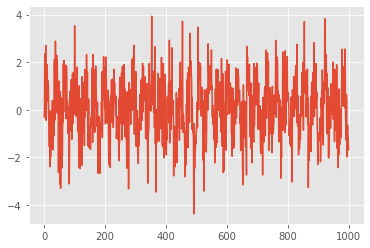

In [47]:
series = np.sin(.2 * np.arange(1000)) + np.random.randn(1000)

plt.plot(series)

In [48]:
T = 10
X = []
Y =[]

for t in range(len(series)-T):
  x = series[t:t+T]
  y = series[t+T]
  X.append(x)
  Y.append(y)

N = len(X)
X = np.array(X).reshape(N,T,1)
Y = np.array(Y).reshape(-1,1)

In [49]:
print(X.shape,Y.shape)

(990, 10, 1) (990, 1)


In [50]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [51]:
class RecurNN(torch.nn.Module):

  def __init__(self,n_inputs,n_hidden,n_outputs,n_rnnlayer):
    super(RecurNN,self).__init__()

    self.num_input = n_inputs
    self.num_hidden = n_hidden
    self.num_output = n_outputs
    self.num_rnn = n_rnnlayer


    # NxTxD
    self.rnn = torch.nn.RNN(
        self.num_input,
        self.num_hidden,
        self.num_rnn,
        nonlinearity='tanh',
        batch_first=True
      )
    
    self.fc = torch.nn.Linear(self.num_hidden,self.num_output)
    
  def forward(self,X):
    #initialize h0 as 0 : N_RNN x D x N_HIDDEN
    h0 = torch.zeros(self.num_rnn, X.shape[0],self.num_hidden).to(device)


    #out : N_INPUT x T x N_HIDDEN
    # _ : value in the hidden states
    out, _ = self.rnn(X,h0)

    #
    last_val = out[:,-1,:]
    out = self.fc(last_val)

    return out




In [52]:
model = RecurNN(1,9,1,1)
model.to(device)

RecurNN(
  (rnn): RNN(1, 9, batch_first=True)
  (fc): Linear(in_features=9, out_features=1, bias=True)
)

In [53]:
loss = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr= .01)

In [54]:
X_train = X[:N//2].astype(np.float32)
X_train = torch.from_numpy(X_train).to(device)

X_test = X[:N//2].astype(np.float32)
X_test = torch.from_numpy(X_test).to(device)


Y_train = Y[N//2:].astype(np.float32)
Y_train = torch.from_numpy(Y_train).to(device)

Y_test = Y[N//2:].astype(np.float32)
Y_test = torch.from_numpy(Y_test).to(device)

In [55]:
def gd(X_train,X_test,Y_train,Y_test,optimizer,loss,model,n_iter):

  train_loss = []
  test_loss = []

  for it in range(n_iter):

    optimizer.zero_grad()

    out =  model(X_train)

    _loss = loss(out,Y_train)

    _loss.backward()
    optimizer.step()

    train_loss.append(_loss.item())
    
    # ------------------------
    out = model(X_test)
    _loss = loss(out,Y_test)

    test_loss.append(_loss.item())

  plt.close()
  plt.plot(test_loss, label= "test-loss")
  plt.plot(train_loss, label= "train-loss")
  plt.show()

  return model


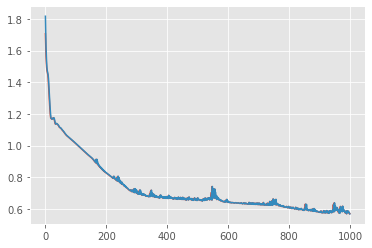

RecurNN(
  (rnn): RNN(1, 9, batch_first=True)
  (fc): Linear(in_features=9, out_features=1, bias=True)
)

In [56]:
gd(X_train,X_test,Y_train,Y_test,optimizer,loss,model,n_iter=1000)

In [115]:
validation = Y[-N//2:]
predictions = []

idx = X_train[0].view(10)


for i in range(len(validation)):
  _pred = idx.view(1,10,1).to(device)
  out = model(_pred)

  #print(out.shape, _pred.shape)

  predictions.append(out.item())
  prev = (idx[1:].tolist())
  prev.append(out.item())

  idx = torch.Tensor(prev).view(10)

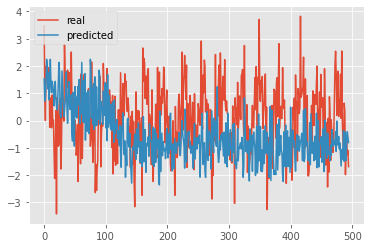

In [116]:
plt.close()
plt.plot(validation, label="real")
plt.plot(predictions, label="predicted")
plt.legend()
plt.show()